In [1]:
import psycopg2 as pg2
import pandas as pd

con = pg2.connect(host='localhost', user='postgres', database='postgres', password='passpostgres')
con.autocommit = True
cur = con.cursor()

def select(sql):
    return pd.read_sql(sql,con)

In [19]:
sql = '''
drop table if exists sales_month;
create table sales_month as

select a.* , b.invoice_count, b.price_sum, 1 as customer,
case when b.invoice_count > 0 then 1 else 0 end as active,

max(case when b.invoice_count > 0 then a.month else null end) over (partition by a.customerid order by a.month) as last_transaction,

extract(year from age(a.month, max(case when b.invoice_count > 0 then a.month else null end) over (partition by a.customerid order by a.month))) * 12 +
extract(month from age(a.month, max(case when b.invoice_count > 0 then a.month else null end) over (partition by a.customerid order by a.month)))
as last_order_count

from user_month_1 a
left join sales_month_agg b
on a.customerid = b.customerid and a.month = b.month

'''

In [20]:
cur.execute(sql)

In [21]:
sql = '''select * from sales_month a 
where customerid = 12370.0
order by a.month'''

In [22]:
select(sql)

,customerid,reg_month,month,invoice_count,price_sum,customer,active,last_transaction,last_order_count
0,12370.0,2010-12-01,2010-12-01,2.0,1868.02,1,1,2010-12-01,0.0
1,12370.0,2010-12-01,2011-01-01,NaN,NaN,1,0,2010-12-01,1.0
2,12370.0,2010-12-01,2011-02-01,NaN,NaN,1,0,2010-12-01,2.0
3,12370.0,2010-12-01,2011-03-01,1.0,938.39,1,1,2011-03-01,0.0
4,12370.0,2010-12-01,2011-04-01,NaN,NaN,1,0,2011-03-01,1.0
5,12370.0,2010-12-01,2011-05-01,NaN,NaN,1,0,2011-03-01,2.0
6,12370.0,2010-12-01,2011-06-01,NaN,NaN,1,0,2011-03-01,3.0
7,12370.0,2010-12-01,2011-07-01,NaN,NaN,1,0,2011-03-01,4.0
8,12370.0,2010-12-01,2011-08-01,NaN,NaN,1,0,2011-03-01,5.0
9,12370.0,2010-12-01,2011-09-01,NaN,NaN,1,0,2011-03-01,6.0


In [52]:
sql = '''select a.month, sum(a.customer) as cust_count,
sum(a.invoice_count) as invoice,
sum(a.price_sum) as revenue,
sum(a.active) as active,
sum(a.active) * 1.0 / sum(a.customer) as active_pct,

lag(sum(a.customer), 1) over (order by a.month) as prev_cust,

sum(case when a.last_order_count >= 2 then 1 else 0 end) as churn_2month_count,
sum(case when a.last_order_count >= 3 then 1 else 0 end) as churn_3month_count,
sum(case when a.last_order_count >= 4 then 1 else 0 end) as churn_4month_count,
sum(case when a.last_order_count >= 5 then 1 else 0 end) as churn_5month_count,
sum(case when a.last_order_count >= 6 then 1 else 0 end) as churn_6month_count,


sum(case when a.last_order_count >= 2 then 1 else 0 end) * 1.0 / lag(sum(a.customer), 1) over (order by a.month) as churn_2month_cnt_pct,
sum(case when a.last_order_count >= 3 then 1 else 0 end) * 1.0 / lag(sum(a.customer), 1) over (order by a.month) as churn_3month_cnt_pct,
sum(case when a.last_order_count >= 4 then 1 else 0 end) * 1.0 / lag(sum(a.customer), 1) over (order by a.month) as churn_4month_cnt_pct,
sum(case when a.last_order_count >= 5 then 1 else 0 end) * 1.0 / lag(sum(a.customer), 1) over (order by a.month) as churn_5month_cnt_pct,
sum(case when a.last_order_count >= 6 then 1 else 0 end) * 1.0 / lag(sum(a.customer), 1) over (order by a.month) as churn_6month_cnt_pct

from sales_month a 
group by a.month
order by a.month'''

In [53]:
df = select(sql)

In [45]:
for i in range (11,13):
    print(f'sum(case when a.last_order_count >= {i} then 1 else 0 end) * 1.0 / lag(sum(a.customer), 1) over (order by a.month) as churn_{i}month_cnt_pct,')

sum(case when a.last_order_count >= 11 then 1 else 0 end) * 1.0 / lag(sum(a.customer), 1) over (order by a.month) as churn_11month_cnt_pct,
sum(case when a.last_order_count >= 12 then 1 else 0 end) * 1.0 / lag(sum(a.customer), 1) over (order by a.month) as churn_12month_cnt_pct,


In [54]:
df

,month,cust_count,invoice,revenue,active,active_pct,prev_cust,churn_2month_count,churn_3month_count,churn_4month_count,churn_5month_count,churn_6month_count,churn_2month_cnt_pct,churn_3month_cnt_pct,churn_4month_cnt_pct,churn_5month_cnt_pct,churn_6month_cnt_pct
0,2010-12-01,948,1708.0,554604.020,948,1.000000,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,2011-01-01,1369,1236.0,475074.380,783,0.571950,948.0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2011-02-01,1749,1202.0,436546.150,798,0.456261,1369.0,467,0,0,0,0,0.341125,0.000000,0.000000,0.000000,0.000000
3,2011-03-01,2189,1619.0,579964.610,1020,0.465966,1749.0,716,377,0,0,0,0.409377,0.215552,0.000000,0.000000,0.000000
4,2011-04-01,2488,1384.0,426047.851,899,0.361334,2189.0,915,582,316,0,0,0.417999,0.265875,0.144358,0.000000,0.000000
5,2011-05-01,2767,1849.0,648251.080,1079,0.389953,2488.0,1188,740,491,278,0,0.477492,0.297428,0.197347,0.111736,0.000000
6,2011-06-01,3002,1707.0,608013.160,1051,0.350100,2767.0,1336,978,631,426,250,0.482833,0.353451,0.228045,0.153957,0.090351
7,2011-07-01,3193,1593.0,574238.481,993,0.310993,3002.0,1564,1129,852,559,381,0.520986,0.376083,0.283811,0.186209,0.126915
8,2011-08-01,3360,1544.0,616368.000,980,0.291667,3193.0,1820,1367,1022,781,515,0.569997,0.428124,0.320075,0.244598,0.161290
9,2011-09-01,3658,2078.0,931440.372,1302,0.355932,3360.0,1841,1462,1141,879,684,0.547917,0.435119,0.339583,0.261607,0.203571


In [55]:
df.columns

Index(['month', 'cust_count', 'invoice', 'revenue', 'active', 'active_pct',
       'prev_cust', 'churn_2month_count', 'churn_3month_count',
       'churn_4month_count', 'churn_5month_count', 'churn_6month_count',
       'churn_2month_cnt_pct', 'churn_3month_cnt_pct', 'churn_4month_cnt_pct',
       'churn_5month_cnt_pct', 'churn_6month_cnt_pct'],
      dtype='object')

<AxesSubplot:>

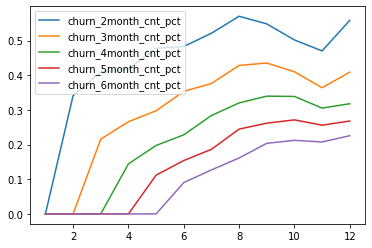

In [51]:
df[['churn_2month_cnt_pct', 'churn_3month_cnt_pct', 'churn_4month_cnt_pct',
       'churn_5month_cnt_pct', 'churn_6month_cnt_pct']].plot()